# Image Data Augmentation


This lab was adapted from https://www.manning.com/books/deep-learning-with-python, Chapter 5

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in 
practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on 
classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 
pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We 
will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be 
achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce 
*data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve 
our network to reach an accuracy of 82%.

In the next section, we will review two more essential techniques for applying deep learning to small datasets: *doing feature extraction 
with a pre-trained network* (this will get us to an accuracy of 90% to 93%), and *fine-tuning a pre-trained network* (this will get us to 
our final accuracy of 95%). Together, these three strategies -- training a small model from scratch, doing feature extracting using a 
pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer 
vision with small datasets.

## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental 
characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual 
feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where 
the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for 
starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can 
potentially suffice if the model is small and well-regularized and if the task is simple. 
Because convnets learn local, translation-invariant features, they are very 
data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results 
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model 
trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of 
computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used 
to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision 
competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at: 
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 
95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our 
models on less than 10% of the data that was available to the competitors.
This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading 
and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation 
set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

### Dependencies

In [2]:
! pip install torchinfo

In [3]:
import os
import shutil
import glob
import random
import concurrent
import zipfile
import torch
import PIL
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset
from IPython.display import Image
from torchinfo import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Download data & unzip:

Download the dataset from https://www.kaggle.com/c/dogs-vs-cats/data.

Zip it and move it to your Google drive.

In [4]:
import os
from google.colab import drive

drive.mount('/content/drive') # mount the drive



Mounted at /content/drive


Unzip the file and save to a folder in your google drive. 

Note, change the path to where you leave the zip file in the lines below

In [ ]:
cwd = os.getcwd()
print(cwd)
os.chdir('/content/drive/MyDrive/BIA667_Lab')

cwd = os.getcwd()

print(cwd)

/content/drive/MyDrive/BIA667_Lab
/content/drive/MyDrive/BIA667_Lab


In [ ]:
# Unzip the files to your google drive

with zipfile.ZipFile(os.path.join(cwd, 'dog_cats.zip'), 'r') as zip_ref:
    zip_ref.extractall('./')

### Re-organize data & generate small sample:

Dir structure:

In [ ]:
# cwd
cwd = os.getcwd()

# dirs
dog_cat_dir = os.path.join(cwd, 'dog_cat')
if not os.path.exists(dog_cat_dir):
    os.mkdir(dog_cat_dir)

cat_dir = os.path.join(dog_cat_dir, 'cat')
if not os.path.exists(cat_dir):
    os.mkdir(cat_dir)
    
dog_dir = os.path.join(dog_cat_dir, 'dog')
if not os.path.exists(dog_dir):
    os.mkdir(dog_dir)

# sample random 1000 pics for cats & dogs
cat_pics = np.random.choice(glob.glob(os.path.join(cwd, 'train', 'cat.*.jpg')), size=1000, replace=False)
dog_pics = np.random.choice(glob.glob(os.path.join(cwd, 'train', 'dog.*.jpg')), size=1000, replace=False)

# move to dir
def move_to_folder(scr_file, des_folder):
    des_name = os.path.basename(scr_file)
    shutil.copyfile(scr_file, os.path.join(des_folder, des_name))
# cats
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as pool:
    [pool.submit(move_to_folder, file_name, cat_dir) for file_name in cat_pics]
# dogs
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as pool:
    [pool.submit(move_to_folder, file_name, dog_dir) for file_name in dog_pics]

In [ ]:
print(os.listdir(cat_dir)[:10])
print(os.listdir(dog_dir)[:10])

['cat.9364.jpg', 'cat.6242.jpg', 'cat.5122.jpg', 'cat.1095.jpg', 'cat.4210.jpg', 'cat.9023.jpg', 'cat.9280.jpg', 'cat.2765.jpg', 'cat.7621.jpg', 'cat.1231.jpg']
['dog.11506.jpg', 'dog.4292.jpg', 'dog.9579.jpg', 'dog.2306.jpg', 'dog.9640.jpg', 'dog.8689.jpg', 'dog.4635.jpg', 'dog.8913.jpg', 'dog.12194.jpg', 'dog.4416.jpg']


### Show a cat and dog example

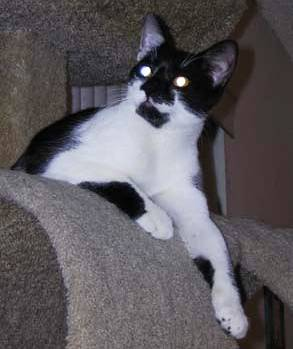

In [ ]:
Image(os.path.join(cat_dir, os.listdir(cat_dir)[0]))

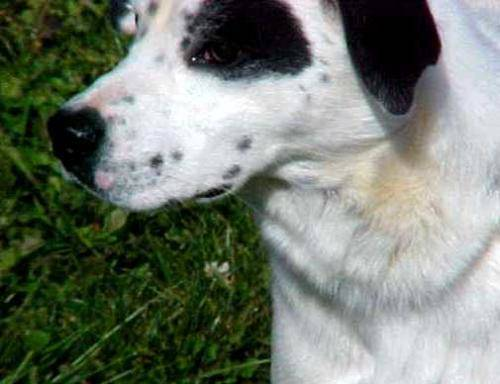

In [ ]:
Image(os.path.join(dog_dir, os.listdir(dog_dir)[0]))

## Define Model

In [ ]:
class CNN_Classifier(nn.Module):
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        # Conv net
        self.convnet = nn.Sequential(
            # input(3, 150, 150)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3), # (32, 148, 148)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 74, 74)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),  # (64, 72, 72)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64, 36, 36)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),  # (128, 34, 34)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128, 17, 17)
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),  # (128, 15, 15)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128, 7, 7)
            nn.Flatten() # 6272 = 128 * 7 * 7
        )
        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=6272, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1)
        )
    
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)

        return x

In [ ]:
sample_model = CNN_Classifier()
summary(sample_model, (10, 3, 150, 150))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Classifier                           --                        --
├─Sequential: 1-1                        [10, 6272]                --
│    └─Conv2d: 2-1                       [10, 32, 148, 148]        896
│    └─ReLU: 2-2                         [10, 32, 148, 148]        --
│    └─MaxPool2d: 2-3                    [10, 32, 74, 74]          --
│    └─Conv2d: 2-4                       [10, 64, 72, 72]          18,496
│    └─ReLU: 2-5                         [10, 64, 72, 72]          --
│    └─MaxPool2d: 2-6                    [10, 64, 36, 36]          --
│    └─Conv2d: 2-7                       [10, 128, 34, 34]         73,856
│    └─ReLU: 2-8                         [10, 128, 34, 34]         --
│    └─MaxPool2d: 2-9                    [10, 128, 17, 17]         --
│    └─Conv2d: 2-10                      [10, 128, 15, 15]         147,584
│    └─ReLU: 2-11                        [10, 128, 15, 15]         --
│

## Dataset

### Self-defined Dataset:

In [ ]:
class ImgDataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if img_transforms is None:
            self.transforms = transforms.ToTensor()
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path)
        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

In [ ]:
images_list = glob.glob(os.path.join(dog_cat_dir, '*', '*.jpg'))
# label: 0 for cat, 1 for dog
def extract_class(img_path):
    base_path = os.path.basename(img_path)
    return base_path.split('.')[0]

labels = [0 if extract_class(cur_path) == 'cat' else 1 for cur_path in images_list]

In [ ]:
resize_transforms = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()])

In [ ]:
dog_cat_dataset = ImgDataset(img_path=images_list, img_labels=labels, img_transforms=resize_transforms)

In [ ]:
print(dog_cat_dataset[0])

dog_cat_dataset[0][0].size()

(tensor([[[0.3373, 0.3020, 0.3373,  ..., 0.2667, 0.2510, 0.2549],
         [0.3098, 0.2941, 0.2980,  ..., 0.2824, 0.2784, 0.2745],
         [0.3020, 0.3059, 0.2824,  ..., 0.2627, 0.2667, 0.2549],
         ...,
         [0.2941, 0.2667, 0.3059,  ..., 0.2039, 0.2000, 0.1961],
         [0.3137, 0.2941, 0.2627,  ..., 0.2000, 0.1961, 0.1961],
         [0.2824, 0.3059, 0.2667,  ..., 0.2000, 0.1961, 0.1961]],

        [[0.3098, 0.2745, 0.3098,  ..., 0.2549, 0.2471, 0.2510],
         [0.2824, 0.2667, 0.2706,  ..., 0.2667, 0.2745, 0.2706],
         [0.2745, 0.2784, 0.2549,  ..., 0.2510, 0.2627, 0.2510],
         ...,
         [0.2706, 0.2431, 0.2824,  ..., 0.1804, 0.1804, 0.1765],
         [0.2902, 0.2706, 0.2392,  ..., 0.1725, 0.1765, 0.1765],
         [0.2588, 0.2824, 0.2431,  ..., 0.1765, 0.1765, 0.1765]],

        [[0.3412, 0.3059, 0.3412,  ..., 0.2784, 0.2706, 0.2745],
         [0.3137, 0.2980, 0.3020,  ..., 0.2941, 0.2980, 0.2941],
         [0.3059, 0.3098, 0.2863,  ..., 0.2784, 0.2863, 0

torch.Size([3, 150, 150])

### ImageFolder:

In [ ]:
from torchvision.datasets import ImageFolder
dog_cat_dataset_folder = ImageFolder(dog_cat_dir, transform=transforms.ToTensor())

In [ ]:
dog_cat_dataset_folder[0]

(tensor([[[0.6000, 0.6039, 0.6118,  ..., 0.2392, 0.2549, 0.2588],
          [0.6000, 0.6039, 0.6078,  ..., 0.2471, 0.2627, 0.2706],
          [0.6078, 0.6118, 0.6118,  ..., 0.2549, 0.2745, 0.2863],
          ...,
          [0.7961, 0.7961, 0.7961,  ..., 0.8078, 0.8078, 0.8078],
          [0.8000, 0.8039, 0.8039,  ..., 0.8118, 0.8118, 0.8118],
          [0.8078, 0.8078, 0.8078,  ..., 0.8118, 0.8118, 0.8118]],
 
         [[0.5843, 0.5882, 0.5961,  ..., 0.1882, 0.2039, 0.2078],
          [0.5843, 0.5882, 0.5922,  ..., 0.1961, 0.2118, 0.2196],
          [0.5922, 0.5961, 0.5961,  ..., 0.2039, 0.2235, 0.2353],
          ...,
          [0.7333, 0.7333, 0.7333,  ..., 0.7294, 0.7294, 0.7294],
          [0.7373, 0.7412, 0.7412,  ..., 0.7333, 0.7333, 0.7333],
          [0.7451, 0.7451, 0.7451,  ..., 0.7333, 0.7333, 0.7333]],
 
         [[0.5373, 0.5412, 0.5490,  ..., 0.1529, 0.1686, 0.1725],
          [0.5373, 0.5412, 0.5451,  ..., 0.1608, 0.1765, 0.1843],
          [0.5451, 0.5490, 0.5490,  ...,

### Split Dataset

In [ ]:
split_size = (np.array([0.6, 0.2, 0.2]) * len(dog_cat_dataset)).round().astype(np.int)
train_data, valid_data, test_data = random_split(dog_cat_dataset, split_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


## Train Function

In [ ]:
def train_model(model, train_dataset, test_dataset, device, 
                lr=0.0001, epochs=30, batch_size=256):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x).view(-1)  # (num_batch)
            cur_train_loss = criterion(outputs, y)
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
            cur_train_acc = (pred == y).sum().item() / batch_size
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x).view(-1)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().item() / batch_size 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f} train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.4f}")
    
    return history

## Train Model

In [ ]:
cnn_model = CNN_Classifier()

In [ ]:
history = train_model(cnn_model, train_data, valid_data, device, batch_size=32, epochs=30, lr=0.0001)

Training Start
Epoch:1 / 30, train loss:0.6971 train_acc:0.4762, valid loss:0.6925 valid acc:0.4808
Epoch:2 / 30, train loss:0.6916 train_acc:0.5148, valid loss:0.6954 valid acc:0.4880
Epoch:3 / 30, train loss:0.6855 train_acc:0.5428, valid loss:0.6842 valid acc:0.5048
Epoch:4 / 30, train loss:0.6743 train_acc:0.5609, valid loss:0.6750 valid acc:0.5361
Epoch:5 / 30, train loss:0.6538 train_acc:0.5880, valid loss:0.6595 valid acc:0.5793
Epoch:6 / 30, train loss:0.6339 train_acc:0.6464, valid loss:0.6583 valid acc:0.5553
Epoch:7 / 30, train loss:0.6201 train_acc:0.6472, valid loss:0.6569 valid acc:0.5962
Epoch:8 / 30, train loss:0.6021 train_acc:0.6776, valid loss:0.6788 valid acc:0.5529
Epoch:9 / 30, train loss:0.5895 train_acc:0.6850, valid loss:0.6352 valid acc:0.6202
Epoch:10 / 30, train loss:0.5551 train_acc:0.7113, valid loss:0.6458 valid acc:0.6154
Epoch:11 / 30, train loss:0.5611 train_acc:0.7039, valid loss:0.6317 valid acc:0.6298
Epoch:12 / 30, train loss:0.5377 train_acc:0.715

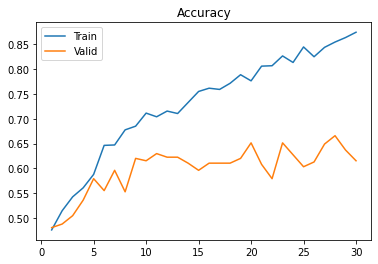

In [ ]:
plt.plot(range(1, 31), history['train_acc'], label='Train')
plt.plot(range(1, 31), history['test_acc'], label='Valid')
plt.title('Accuracy')
plt.legend()
plt.show()

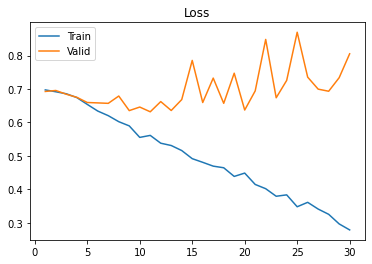

In [ ]:
plt.plot(range(1, 31), history['train_loss'], label='Train')
plt.plot(range(1, 31), history['test_loss'], label='Valid')
plt.title('Loss')
plt.legend()
plt.show()

## Image Data Augmentation

The image transformations are implemented in [torchvision](https://pytorch.org/vision/stable/index.html). Some useful data augmentations:

*   [torchvision.transforms.ColorJitter](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ColorJitter): Randomly change the brightness, contrast, saturation and hue of an image.
*   [torchvision.transforms.RandomHorizontalFlip](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomHorizontalFlip) & [torchvision.transforms.RandomVerticalFlip](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomVerticalFlip): Horizontally or vertically flip the given image randomly with a given probability.
*   [torchvision.transforms.RandomGrayscale(p=0.1)](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomGrayscale): Randomly convert image to grayscale with a a probability.
*   [RandomRotation](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomRotation): Randomly rotate images within certain degrees.






For the full list of availabe tranformations, please see [this](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomRotation). The illustrations of transformations are available [here](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py).

### Image Transformation Example

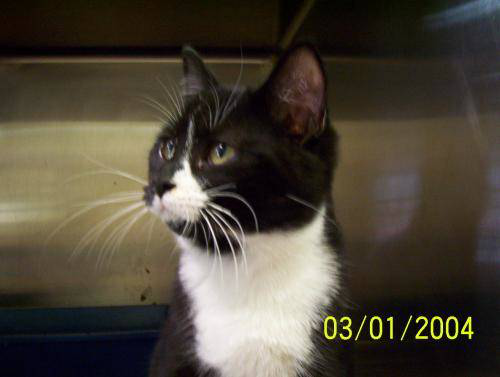

In [ ]:
# get a sample image
sample_img_path = os.path.join(cat_dir, os.listdir(cat_dir)[4])
sample_img = PIL.Image.open(sample_img_path)
display(sample_img)

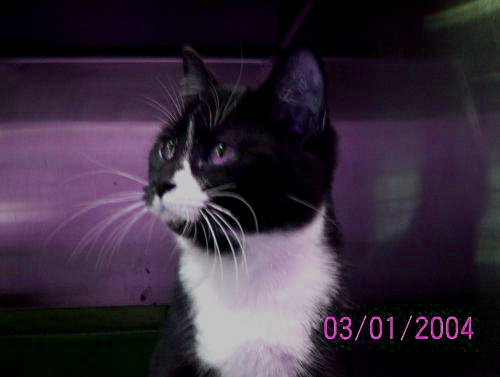

In [ ]:
# apply random color jitter
transformed_img = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)(sample_img)
display(transformed_img)

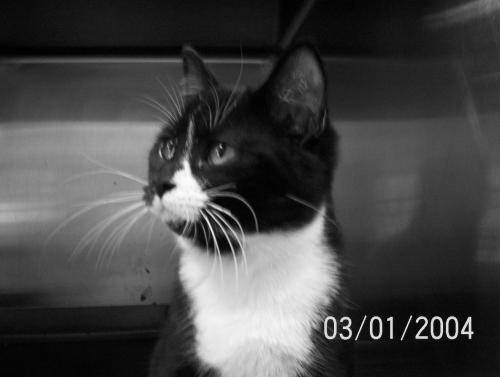

In [ ]:
transformed_img = transforms.RandomGrayscale(p=1.0)(sample_img)
display(transformed_img)

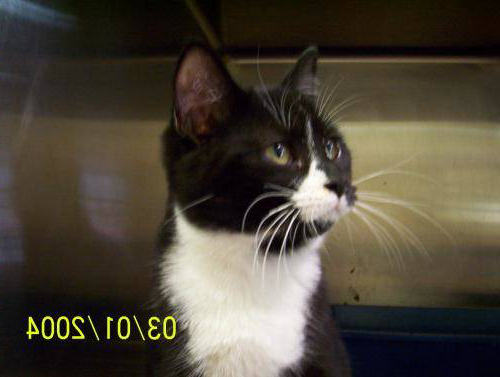

In [ ]:
transformed_img = transforms.RandomHorizontalFlip(p=1.0)(sample_img)
display(transformed_img)

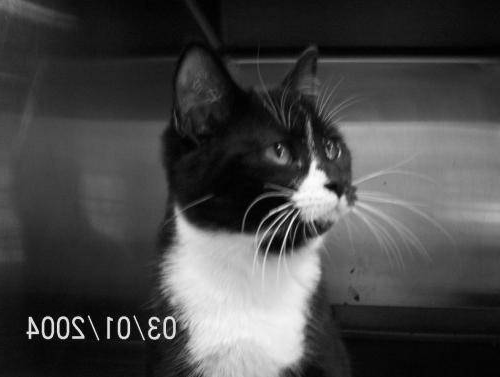

In [ ]:
# Chain the transformations to a pipeline
transform_pipeline = transforms.Compose(
    [transforms.RandomGrayscale(p=1.0), 
     transforms.RandomHorizontalFlip(p=1.0)])

transformed_img = transform_pipeline(sample_img)
display(transformed_img)

### Apply Transfoamation on Dataset

In [ ]:
class ImgDataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if img_transforms is None:
            self.transforms = transforms.ToTensor()
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path)
        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

Build a transformation pipeline:

In [ ]:
transformations = transforms.Compose([transforms.Resize((150, 150)),  # resize to input shape of our CNN
                                      transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
                                      transforms.RandomRotation(40),
                                      transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), shear=0.2),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()  # convert PIL to Tensor
                                      ])

New dataset with transformation pipline:

In [ ]:
dog_cat_dataset_transformed = ImgDataset(img_path=images_list, img_labels=labels, img_transforms=transformations)

split_size = (np.array([0.6, 0.2, 0.2]) * len(dog_cat_dataset_transformed)).round().astype(np.int)
train_data, valid_data, test_data = random_split(dog_cat_dataset_transformed, split_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


### Re-Train CNN Model:

In [ ]:
cnn_model = CNN_Classifier()

In [ ]:
history = train_model(cnn_model, train_data, valid_data, device, batch_size=32, epochs=150, lr=0.0001)

Training Start
Epoch:1 / 150, train loss:0.6941 train_acc:0.4885, valid loss:0.6933 valid acc:0.4712
Epoch:2 / 150, train loss:0.6931 train_acc:0.5115, valid loss:0.6883 valid acc:0.5048
Epoch:3 / 150, train loss:0.6907 train_acc:0.5345, valid loss:0.6817 valid acc:0.5433
Epoch:4 / 150, train loss:0.6813 train_acc:0.5526, valid loss:0.6801 valid acc:0.5216
Epoch:5 / 150, train loss:0.6821 train_acc:0.5469, valid loss:0.6699 valid acc:0.5433
Epoch:6 / 150, train loss:0.6757 train_acc:0.5641, valid loss:0.6637 valid acc:0.5409
Epoch:7 / 150, train loss:0.6664 train_acc:0.5962, valid loss:0.6487 valid acc:0.6154
Epoch:8 / 150, train loss:0.6649 train_acc:0.5715, valid loss:0.6444 valid acc:0.5962
Epoch:9 / 150, train loss:0.6587 train_acc:0.5987, valid loss:0.6393 valid acc:0.6106
Epoch:10 / 150, train loss:0.6556 train_acc:0.6094, valid loss:0.6429 valid acc:0.5721
Epoch:11 / 150, train loss:0.6609 train_acc:0.5905, valid loss:0.6475 valid acc:0.6106
Epoch:12 / 150, train loss:0.6572 tra

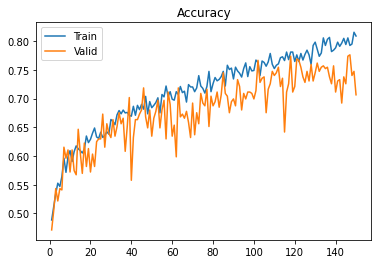

In [ ]:
plt.plot(range(1, 151), history['train_acc'], label='Train')
plt.plot(range(1, 151), history['test_acc'], label='Valid')
plt.title('Accuracy')
plt.legend()
plt.show()

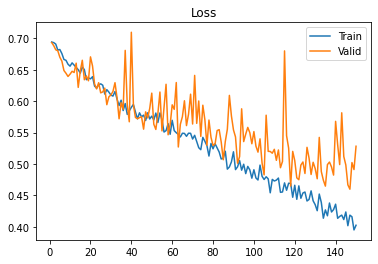

In [ ]:
plt.plot(range(1, 151), history['train_loss'], label='Train')
plt.plot(range(1, 151), history['test_loss'], label='Valid')
plt.title('Loss')
plt.legend()
plt.show()